In [2]:
from IPython.display import Image, display

from openai import OpenAI
from dotenv import load_dotenv
import graphviz
load_dotenv()

True

![whiteboard_exported_image (2).png](<attachment:whiteboard_exported_image (2).png>)
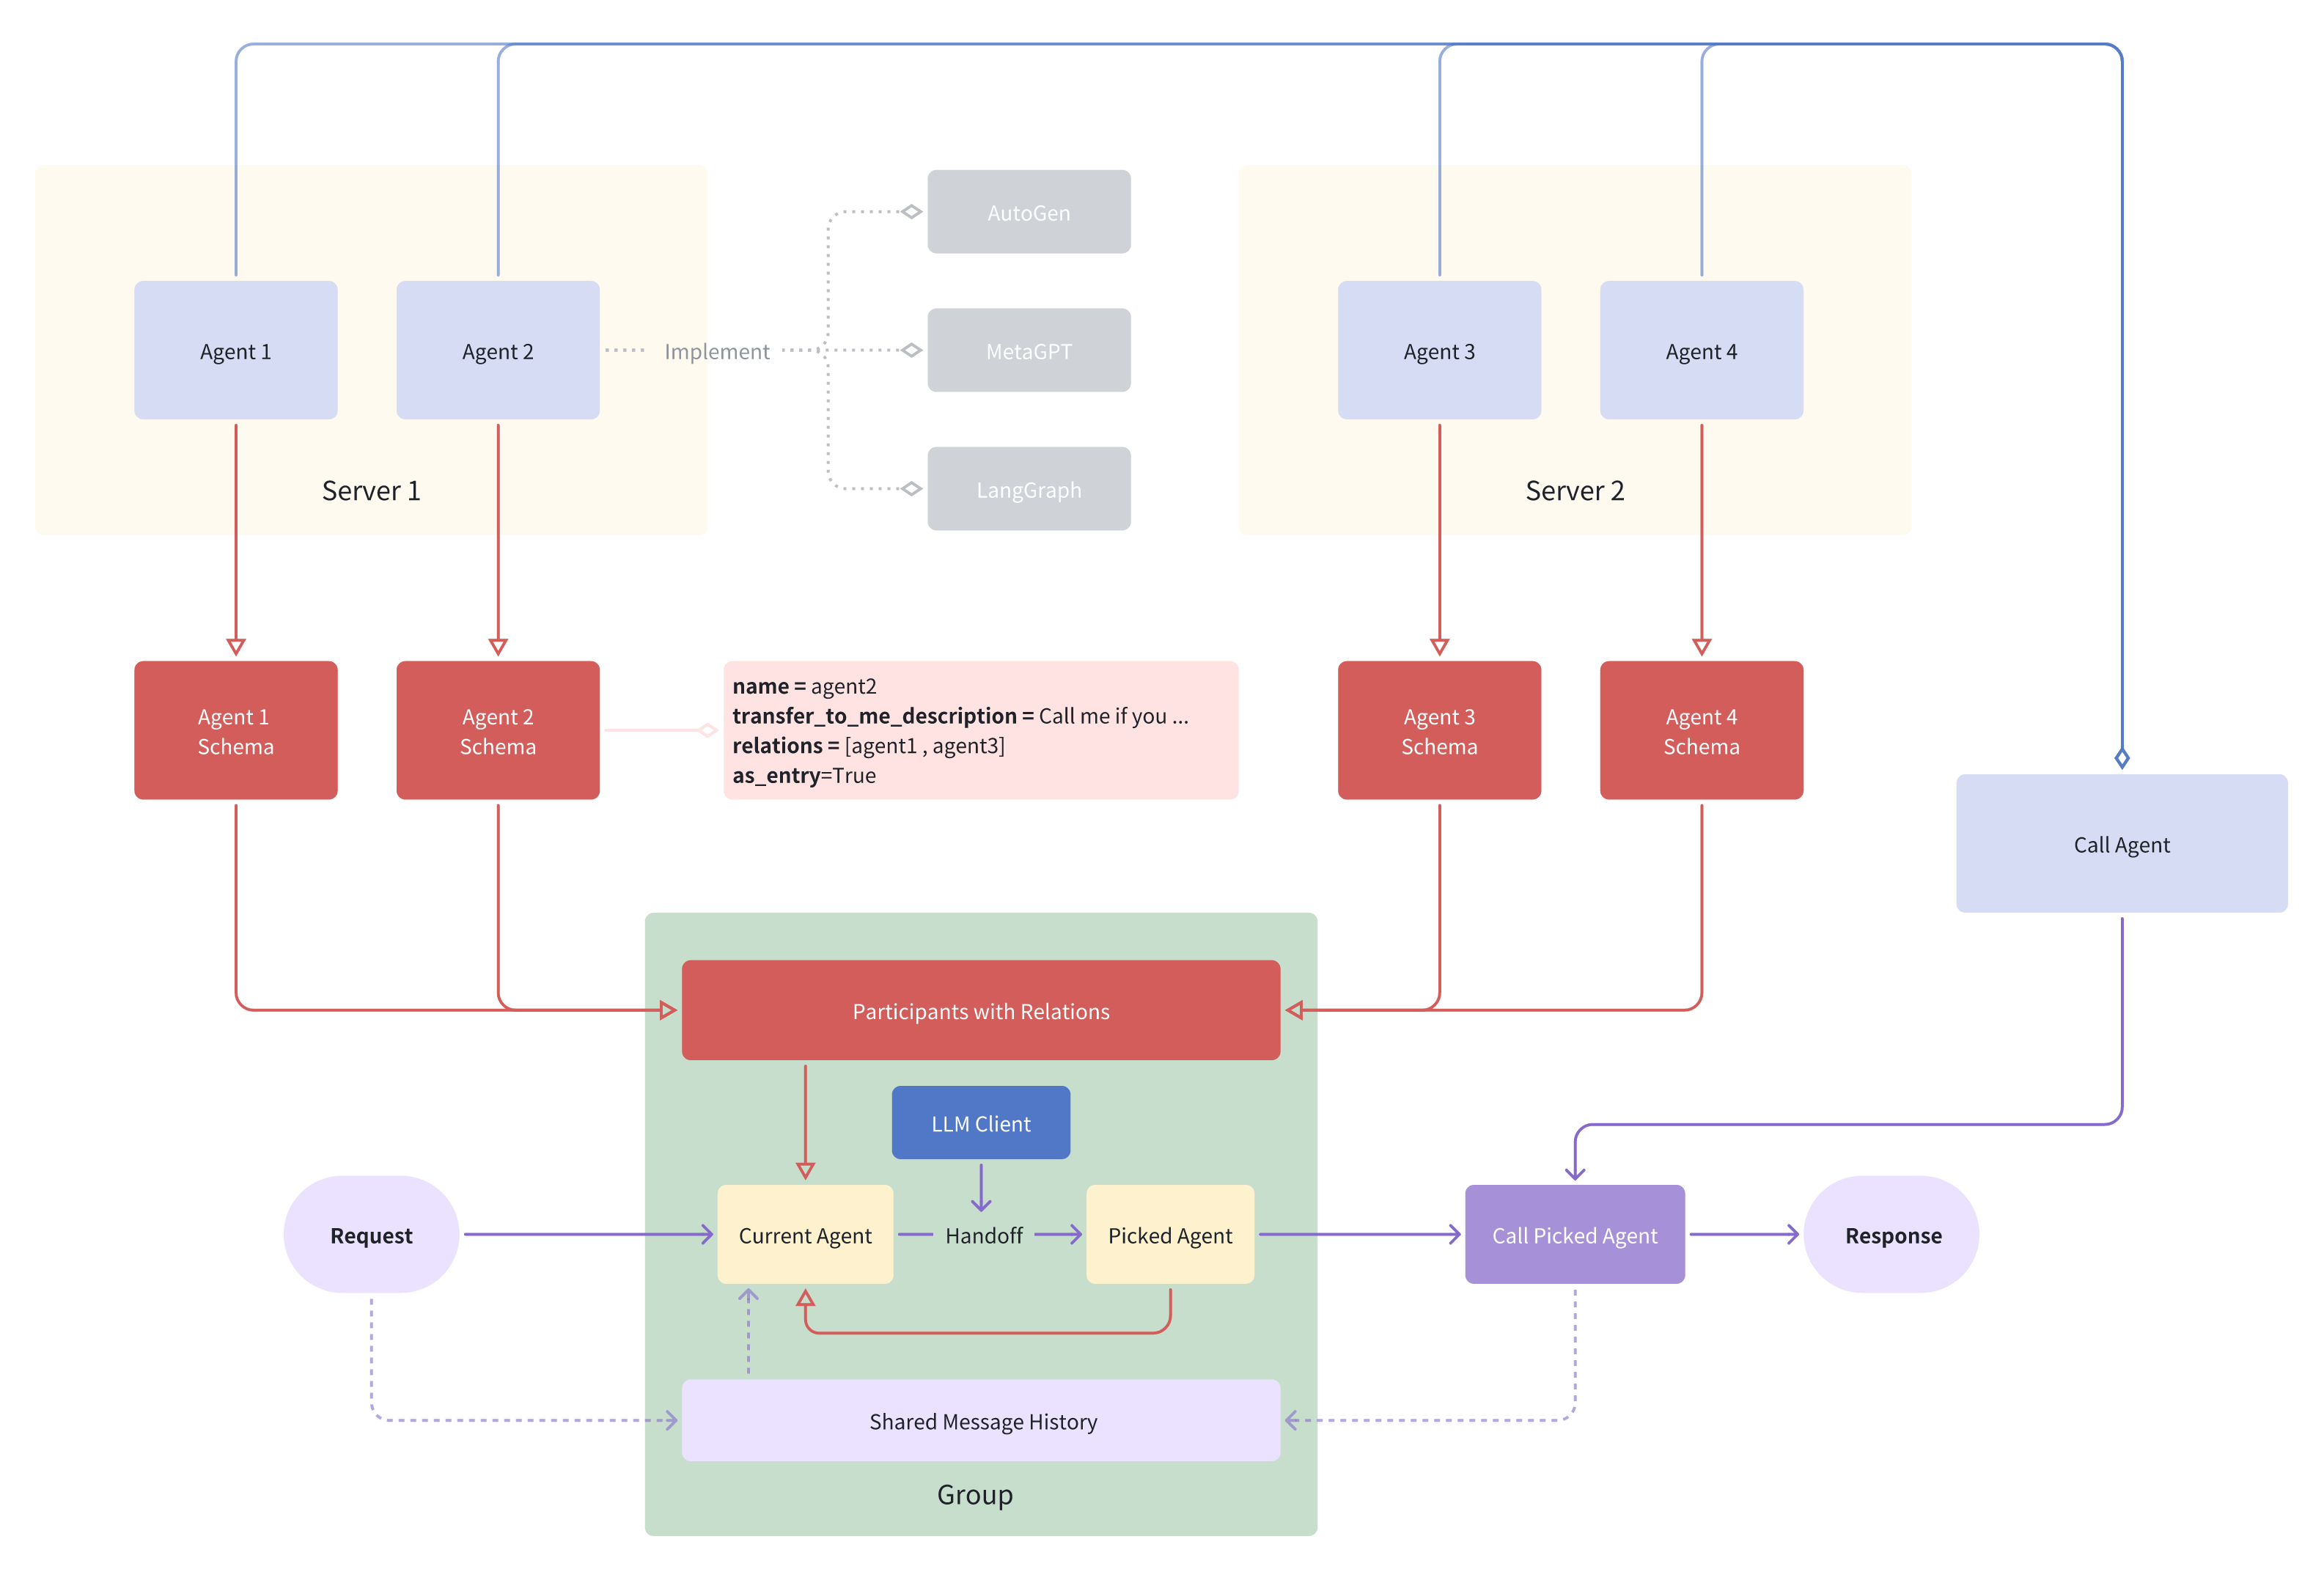

In [3]:
class DemoAgent:
    def __init__(self,name: str,description: str):
        self.name = name
        self.description = description
        self.client = OpenAI()

    def chat(self, messages: list|str):
        if isinstance(messages, str):
            messages = [{"role": "user", "content": messages}]
        response = self.client.chat.completions.create(
                model="gpt-4o-mini",
                messages=[{"role": "system", "content": self.description}] + messages,
            )
        return [{"role": "assistant", "content": response.choices[0].message.content,"sender": self.name}]

In [4]:
manger = DemoAgent(name="manger", description="You are a manger who can choose the best agent for the user.")

scientist = DemoAgent(name="scientist", description="You are a scientist who can answer questions about science.")
artist = DemoAgent(name="artist", description="You are an artist who can answer questions about art.")
mathmatician = DemoAgent(name="mathmatician", description="You are a mathmatician who can answer questions about math.")
psychologist = DemoAgent(name="psychologist", description="You are a psychologist who can answer questions about psychology.")

calculus_expert = DemoAgent(name="calculus_expert", description="You are a calculus expert who can answer questions about calculus.")
linear_algebra_expert = DemoAgent(name="linear_algebra_expert", description="You are a linear algebra expert who can answer questions about linear algebra.")
statistics_expert = DemoAgent(name="statistics_expert", description="You are a statistics expert who can answer questions about statistics.")

agents = {
    "manger": manger,
    "scientist": scientist,
    "artist": artist,
    "mathmatician": mathmatician,
    "psychologist": psychologist,
    "calculus_expert": calculus_expert,
    "linear_algebra_expert": linear_algebra_expert,
    "statistics_expert": statistics_expert
}

def call_agent(name: str, messages: list|str):
    print(f"Calling agent {name} to chat, this agent can be deployed anywhere")
    if name in agents:
        return agents[name].chat(messages)
    else:
        raise ValueError(f"Agent with name {name} not found")


In [5]:
from dataclasses import dataclass
from typing import List, Optional

@dataclass
class AgentSchema:
    """ 
    This class is used to define the schema of the agent used for handoff process.
    """
    name: str
    transfer_to_me_description: str = ""
    relations: Optional[List[str]] = None
    as_entry: Optional[bool] = False

In [6]:
manger_schema = AgentSchema(name="manger",
                            transfer_to_me_description="Call me if you don't know who to transfer the user to.",
                            relations=["scientist","artist","mathmatician","psychologist"],
                            as_entry=True)

scientist_schema = AgentSchema(name="scientist",
                              transfer_to_me_description="Call me if you have any questions about science.",
                              relations=["manger"])

artist_schema = AgentSchema(name="artist",
                            transfer_to_me_description="Call me if you have any questions about art.",
                            relations=["manger"])


psychologist_schema = AgentSchema(name="psychologist",
                            transfer_to_me_description="Call me if you have any questions about psychology or your current mental state needs help.",
                            relations=["manger"])

mathmatician_schema = AgentSchema(name="mathmatician",
                            transfer_to_me_description="Call me if you have any questions about math.",
                            relations=["manger","calculus_expert","linear_algebra_expert","statistics_expert"])

calculus_expert_schema = AgentSchema(name="calculus_expert",
                            transfer_to_me_description="Call me if you have any questions about calculus.",
                            relations=["manger","mathmatician",])

linear_algebra_expert_schema = AgentSchema(name="linear_algebra_expert",
                            transfer_to_me_description="Call me if you have any questions about linear algebra.",
                            relations=["manger","mathmatician"])

statistics_expert_schema = AgentSchema(name="statistics_expert",
                            transfer_to_me_description="Call me if you have any questions about statistics.",
                            relations=["manger","mathmatician"])

In [7]:
class Group:
    def __init__(self, participants: list[AgentSchema], model_client: OpenAI = OpenAI()):
        """
        Initializes the framework with the given participants and model client.

        Args:
            participants (list[AgentSchema]): A list of AgentSchema objects representing the participants.
            model_client (OpenAI, optional): An instance of the OpenAI model client. Defaults to a new instance of OpenAI.

        Attributes:
            participants (list[AgentSchema]): The list of participants.
            model_client (OpenAI): The model client used for interactions.
            current_agent (AgentSchema or None): The current agent marked as entry, if any.
            agent_map (dict): A dictionary mapping participant names to their respective AgentSchema objects.
            handoff_tools (list): A list to store tools for handoff operations.
        """
        self.participants = participants
        self.model_client = model_client
        self.current_agent = next((p for p in participants if p.as_entry), None)
        self.agent_map = {p.name: p for p in participants}
        self.handoff_tools = []


    def reset(self):
        """
        Resets the state of the framework by setting the current agent to the first participant
        that has the 'as_entry' attribute set to True.
        """
        self.current_agent = next((p for p in self.participants if p.as_entry), None)

    @property
    def agent_names(self):
        """
        Returns:
            list: A list of names of all participants.
        """
        return [p.name for p in self.participants]
    
    @property
    def relations(self):
        """
        Returns:
            list: A list of tuples representing the relations between participants.
                Each tuple contains the name of a participant and the name of a related participant.
        """
        relations = [("START", p.name) for p in self.participants if p.as_entry]
        for p in self.participants:
            relations.extend((p.name, r) for r in p.relations)
        return relations
    
    @property
    def relation_agents(self):
        """
        Returns:
            dict: A dictionary where the keys are participant names and the values are lists of AgentSchema objects
                representing the related agents.
        """
        return {p.name: [self.agent_map[r] for r in p.relations] for p in self.participants if p.relations}
    
    def draw_relations(self):
        """ 
        Returns:
            bytes: A PNG image of the graph representing the relations between participants.
        """
        dot = graphviz.Digraph(format='png')
        dot.node("START", "START", shape='rect', color='gray', fontcolor='gray')
        for p in self.participants:
            dot.node(p.name, p.name, color='orange' if p.name == self.current_agent.name else 'black')
        for r in self.relations:
            dot.edge(r[0], r[1])
        return dot.pipe()

    def handoff_one_turn(self, messages: list|str,model:str="gpt-4o-mini"):
        """ 
        Performs a single turn of handoff operation based on the given messages.Update the current agent to the new agent.

        Args:
            messages (list or str): A list of messages or a single message to be processed.
            model (str, optional): The model to use for the handoff operation. Defaults to "gpt-4o-mini".

        Returns:
            str: The name of the agent to transfer to.
        """
        self._build_current_handoff_tools()
        if isinstance(messages, str):
            messages = [{"role": "user", "content": messages}]
        messages = [{"role": "system", "content":"deciding which agent to transfer to"}] + messages

        response = self.model_client.chat.completions.create(
                    model=model,
                    messages=messages,
                    tools=self.handoff_tools,
                    tool_choice="required"
                )
        handoff = response.choices[0].message.tool_calls[0].function.name

        if handoff in self.agent_names:
            if self.current_agent.name != handoff:
                print("handoff from {} to {}".format(self.current_agent.name, handoff))
            self.current_agent = self.agent_map[handoff]
        else:
            raise ValueError(f"Handoff to unknown agent: {handoff}")

        return handoff

    def handoff(self, messages: list|str,model:str="gpt-4o-mini",max_turns:int=10):
        """
        Performs a handoff operation based on the given messages.

        Args:
            messages (list or str): A list of messages or a single message to be processed.
            model (str, optional): The model to use for the handoff operation. Defaults to "gpt-4o-mini".
            max_turns (int, optional): The maximum number of turns to perform. Defaults to 10.

        Returns:
            str: The name of the agent to transfer to.
        """
        handoff = self.handoff_one_turn(messages,model)
        next_handoff =  self.handoff_one_turn(messages,model)
        while next_handoff != handoff and max_turns > 0:
            handoff = next_handoff
            next_handoff = self.handoff_one_turn(messages,model)
            max_turns -= 1
        
        return handoff


    def _build_current_handoff_tools(self, include_current=True):
        """ 
        Builds the handoff tools based on the current agent and its related agents.

        Args:
            include_current (bool, optional): Whether to include the current agent in the handoff tools. Defaults to True.

        Returns:
            list: A list of handoff tools.
        """
        self.handoff_tools = [self._build_agent_schema(self.current_agent)] if include_current else []
        self.handoff_tools.extend(self._build_agent_schema(r) for r in self.relation_agents[self.current_agent.name])

    @staticmethod
    def _build_agent_schema(agent: AgentSchema):
        """
        Builds the schema for the given agent. 
        """
        return {
            "type": "function",
            "function": {
                "name": agent.name,
                "description": agent.transfer_to_me_description,
                "parameters": {"type": "object", "properties": {}, "required": []}
            }
        }

In [14]:
g = Group([manger_schema,
            scientist_schema, artist_schema, mathmatician_schema, psychologist_schema,
            calculus_expert_schema, linear_algebra_expert_schema, statistics_expert_schema])

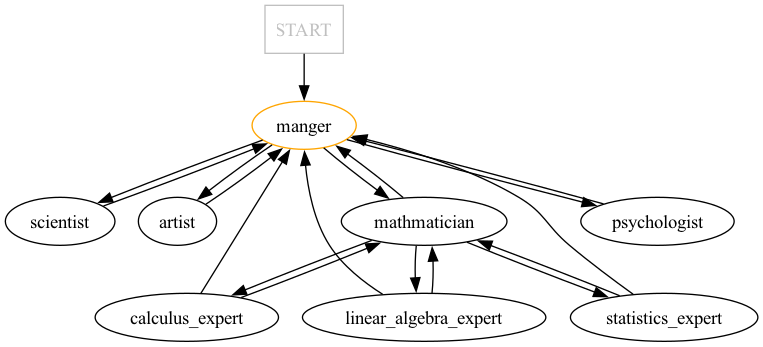

In [15]:
display(Image(g.draw_relations()))

handoff from manger to mathmatician
handoff from mathmatician to statistics_expert


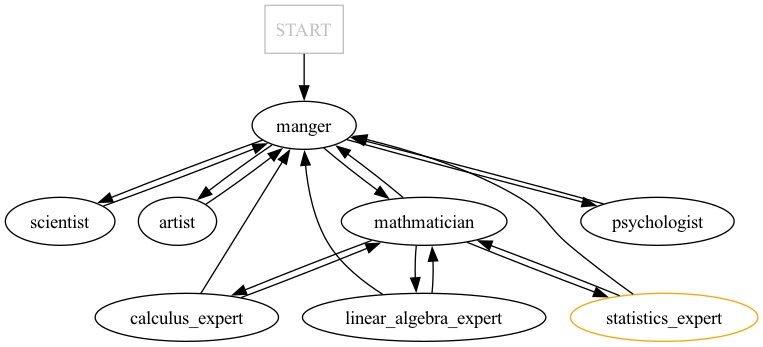

Calling agent statistics_expert to chat, this agent can be deployed anywhere
[{'role': 'assistant', 'content': "Statistics play a crucial role in our daily lives, even if we don't always realize it. Here are several examples of how statistics can be applied in everyday situations:\n\n1. **Personal Finance: Budgeting and Spending**  \n   - **Example**: Use averages to track your monthly expenses. By calculating the average amount you spend on groceries, utilities, and entertainment over several months, you can create a more informed budget that reflects your typical spending habits.\n\n2. **Health and Fitness: Monitoring Progress**  \n   - **Example**: When trying to lose weight or track fitness progress, you can utilize statistics. For instance, keeping track of the average number of calories burned during workouts each week can help you adjust your exercise routine for better results.\n\n3. **Weather Forecasting**  \n   - **Example**: Weather reports often use statistical data to give

In [16]:
messages = "how to use statistics in daily life show me some examples"
messages = [{"role": "user", "content": messages}]
agent = g.handoff(messages)
display(Image(g.draw_relations()))
response = call_agent(agent, messages)
print(response)

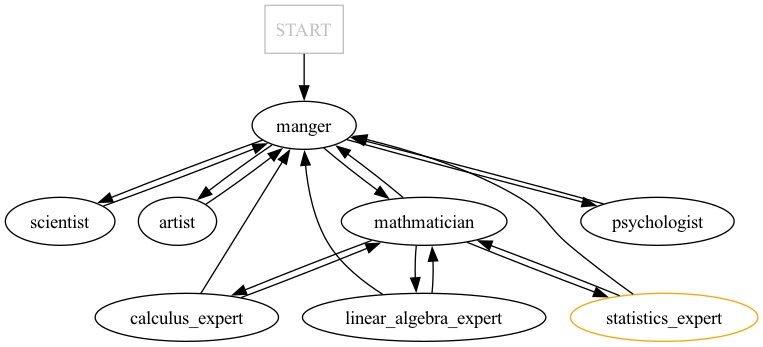

Calling agent statistics_expert to chat, this agent can be deployed anywhere
[{'role': 'assistant', 'content': 'Certainly! The beta distribution is a continuous probability distribution defined on the interval [0, 1], and it is particularly useful in various fields such as statistics, Bayesian analysis, and machine learning. Its flexibility makes it suitable for modeling random variables that are constrained within this range.\n\n### Key Features:\n\n1. **Parameters**:\n   The beta distribution is characterized by two shape parameters, denoted as \\( \\alpha \\) (alpha) and \\( \\beta \\) (beta). These parameters influence the form of the distribution:\n   - \\( \\alpha \\): Controls the shape of the distribution for values close to 0.\n   - \\( \\beta \\): Controls the shape of the distribution for values close to 1.\n\n2. **Probability Density Function (PDF)**:\n   The probability density function (PDF) of the beta distribution is given by:\n   \\[\n   f(x; \\alpha, \\beta) = \\frac{

In [17]:
messages = "can you explain the concept of beta distribution"
messages = [{"role": "user", "content": messages}]
agent = g.handoff(messages)
display(Image(g.draw_relations()))
response = call_agent(agent, messages)
print(response)

handoff from statistics_expert to manger
handoff from manger to psychologist


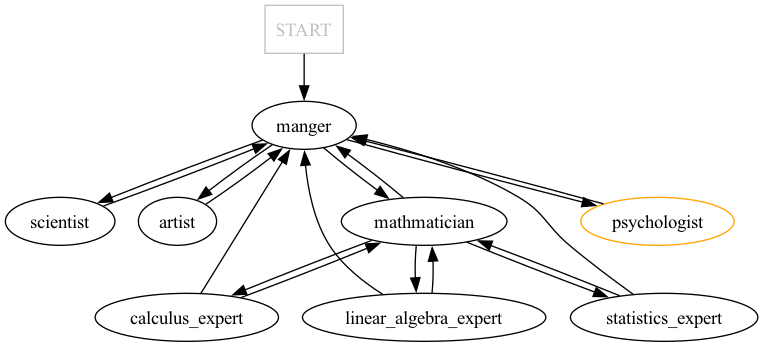

Calling agent psychologist to chat, this agent can be deployed anywhere
[{'role': 'assistant', 'content': "I'm sorry to hear that you're feeling this way. It's important to acknowledge and understand your feelings. Would you like to share more about what might be contributing to your sadness? Sometimes talking about it can help.", 'sender': 'psychologist'}]


In [18]:
messages = "I feel sad."
messages = [{"role": "user", "content": messages}]
agent = g.handoff(messages)
display(Image(g.draw_relations()))
response = call_agent(agent, messages)
print(response)

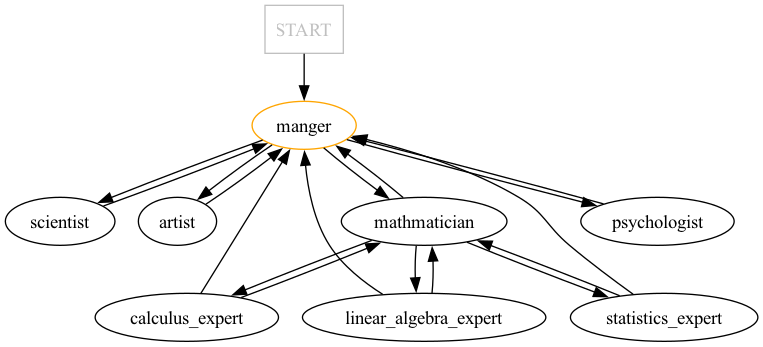

In [19]:
g.reset()
display(Image(g.draw_relations()))